## Цель работы
Изучение методов классификации данных, реализованные в библиотеке Scikit-Learn, а также ознакомление с нейронными сетями с использованием библиотек TensorFlow и TensorBoard.

## Постановка задачи


Необходимо выбрать и подготовить дата для классификации, затем построить классификационные модели с помощью пяти методов:

a. Наивный Байесовский классификатор (GaussianNB, MultinomialNB, ComplementNB, BernoulliNB);

b. Деревья решений (Decision Tree);

c. Линейный дискриминантный анализ (Linear Discriminant Analysis);

d. Метод опорных векторов (Support Vector Machines);

e. Метод ближайших соседей (k-Nearest Neighbors);

Затем сравните качество работы классификаторов с помощью следующих метрик:

a. Accuracy (точность),

b. Precision (доля правильно классифицированных положительных примеров),

c. Recall (чувствительность, доля верно найденных положительных примеров),

d. F1-Score (среднее гармоническое precision и recall),

e. Площадь под кривой ROC (AUC-ROC).

Настройте гиперпараметры каждого метода и проведите исследование влияния различных параметров на качество классификации.

Реализуйте и протестируйте нейронную сеть на TensorFlow, исследуйте эффект настройки гиперпараметров и визуализируйте процесс обучения с помощью инструмента TensorBoard.

### Выбор и описание датасета

Дл работы был выбран датасет https://www.kaggle.com/datasets/yasserh/wine-quality-dataset

Признаки:
1. fixed acidity - фиксируемая кислотность
2. volatile acidity - летучая кислотность
3. citric acid - лимонная кислота
4. residual sugar - остаточный сахар
5. chlorides - хлориды
6. free sulfur dioxide - свободный диоксид серы
7. total sulfur dioxide - общий диоксид серы
8. density - плотность
9. pH - кислотность среды
10. sulphates - сульфаты
11. alcohol - содержание алкоголя (в %)
12. quality - качество (от 0 до 10)

### Анализ параметров
Посмотрим на исходные классы

/home/nikita/Machine-Learning/Lab-3/venv/lib64/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5  
3      9.8        6  
4      9.4        5

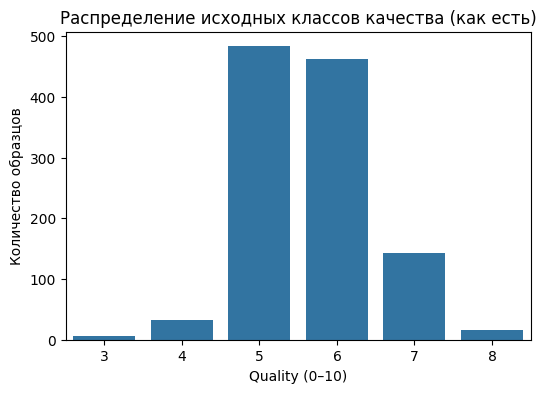

Оригинальные классы:
 quality
3      6
4     33
5    483
6    462
7    143
8     16
Name: count, dtype: int64


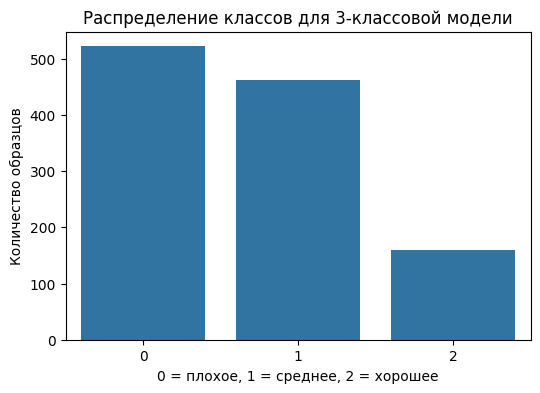


3-классовое распределение:
 quality_3class
0    522
1    462
2    159
Name: count, dtype: int64


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import kagglehub

file_path = "WineQT.csv"

df = kagglehub.dataset_load(
    kagglehub.KaggleDatasetAdapter.PANDAS,
    "yasserh/wine-quality-dataset",
    file_path,
)

df = df.drop(columns=["Id"])
display(df.head())


plt.figure(figsize=(6,4))
sb.countplot(x=df["quality"])
plt.title("Распределение исходных классов качества (как есть)")
plt.xlabel("Quality (0–10)")
plt.ylabel("Количество образцов")
plt.show()

print("Оригинальные классы:\n", df["quality"].value_counts().sort_index())

def map_quality_3(q):
    if q <= 5:
        return 0
    elif q == 6:
        return 1
    else:
        return 2

df["quality_3class"] = df["quality"].apply(map_quality_3)


plt.figure(figsize=(6,4))
sb.countplot(x=df["quality_3class"])
plt.title("Распределение классов для 3-классовой модели")
plt.xlabel("0 = плохое, 1 = среднее, 2 = хорошее")
plt.ylabel("Количество образцов")
plt.show()

print("\n3-классовое распределение:\n", df["quality_3class"].value_counts())

Видно что в исходной выборке нет вин с quantity меньше 3 и больше 8. Поэтому создадим из исходных 10 классов 3 класса (1-5, 6, 7-10)

### Разбиение на тренировочную и тестовую выборки

In [2]:
X = df.drop(columns=["quality", "quality_3class"])
y = df["quality_3class"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=56,
    stratify=y
)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Функция для вывода метрик, построения ROC кривых и матрицы ошибок

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.preprocessing import label_binarize

def get_metrics(y_true, y_pred, y_score, class_names=None):
    classes = np.unique(y_true)
    names   = class_names or [str(c) for c in classes]
    avgs    = ['micro','macro','weighted']

    acc = accuracy_score(y_true, y_pred)

    p_c, r_c, f_c, _ = precision_recall_fscore_support(
        y_true, y_pred, labels=classes, average=None, zero_division=0
    )
    y_bin = label_binarize(y_true, classes=classes)

    auc_c = []
    for i in range(len(classes)):
        try:
            auc_val = roc_auc_score(y_bin[:, i], y_score[:, i])
        except:
            auc_val = np.nan
        auc_c.append(auc_val)

    cols = ['Precision','Recall','F1','Accuracy','ROC AUC']
    df_classes = pd.DataFrame(
        np.column_stack([p_c, r_c, f_c, np.full_like(p_c, np.nan), auc_c]),
        index=names,
        columns=cols
    )

    df_aggs = pd.DataFrame([
        [
            *precision_recall_fscore_support(
                y_true, y_pred, average=a, zero_division=0
            )[:3],
            acc,
            roc_auc_score(y_true, y_score, multi_class='ovr', average=a)
        ]
        for a in avgs
    ], index=avgs, columns=cols)

    df = pd.concat([df_classes, df_aggs])

    for c in ['Precision','Recall','F1','ROC AUC']:
        df[c] = df[c].astype(float).round(4)

    df['Accuracy'] = df['Accuracy'].astype('object')
    df.loc[names, 'Accuracy'] = ''
    df.loc[avgs,  'Accuracy'] = df.loc[avgs, 'Accuracy'].astype(float).round(4)

    display(df)

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    ConfusionMatrixDisplay(
        confusion_matrix(y_true, y_pred, labels=classes),
        display_labels=names
    ).plot(ax=axes[0], cmap='Blues', colorbar=False)

    axes[0].set_title('Матрица ошибок')

    for i, name in enumerate(names):
        try:
            fpr, tpr, _ = roc_curve(y_bin[:, i], y_score[:, i])
            axes[1].plot(fpr, tpr, lw=2, label=name)
        except:
            continue

    axes[1].plot([0,1], [0,1], '--', lw=1)
    axes[1].set(
        xlabel='FPR',
        ylabel='TPR',
        title='ROC (OvR)'
    )
    axes[1].legend(loc='lower right')

    plt.tight_layout()
    plt.show()

    return df


### Наивный Байесовский классификатор
Наивный байесовский классификатор (Naive Bayes classifier) — вероятностный классификатор на основе формулы Байеса со строгим (наивным) предположением о независимости признаков между собой при заданном классе, что сильно упрощает задачу классификации из-за оценки одномерных вероятностных плотностей вместо одной многомерной.

GaussianNB — это реализация Наивного Байесовского классификатора в библиотеке scikit-learn, предназначенная для непрерывных данных, где предполагается, что признаки в каждом классе распределены нормально (по закону Гаусса).



### Подбор параметров классификации 
Будем подбирать параметр var_smoothing - добавочная дисперсия

In [4]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold, cross_val_score

import numpy as np
var_grid = np.concatenate([
    [0.0],
    np.logspace(-15, -1, 15),
    np.logspace(0, 5, 6)
])

best_score = 0
best_var = None

for var in var_grid:
    gnb = GaussianNB(var_smoothing=var)
    scores = cross_val_score(gnb, X_train_scaled, y_train, cv=5, scoring='accuracy')
    mean_score = scores.mean()
    print(f"var_smoothing={var:.0e} -> Accuracy CV={mean_score:.4f}")
    
    if mean_score > best_score:
        best_score = mean_score
        best_var = var

print(f"\nЛучший var_smoothing: {best_var:.0e} с Accuracy CV={best_score:.4f}")

var_smoothing=0e+00 -> Accuracy CV=0.5985
var_smoothing=1e-15 -> Accuracy CV=0.5985
var_smoothing=1e-14 -> Accuracy CV=0.5985
var_smoothing=1e-13 -> Accuracy CV=0.5985
var_smoothing=1e-12 -> Accuracy CV=0.5985
var_smoothing=1e-11 -> Accuracy CV=0.5985
var_smoothing=1e-10 -> Accuracy CV=0.5985
var_smoothing=1e-09 -> Accuracy CV=0.5985
var_smoothing=1e-08 -> Accuracy CV=0.5985
var_smoothing=1e-07 -> Accuracy CV=0.5985
var_smoothing=1e-06 -> Accuracy CV=0.5985
var_smoothing=1e-05 -> Accuracy CV=0.5985
var_smoothing=1e-04 -> Accuracy CV=0.5985
var_smoothing=1e-03 -> Accuracy CV=0.5985
var_smoothing=1e-02 -> Accuracy CV=0.5963
var_smoothing=1e-01 -> Accuracy CV=0.6062
var_smoothing=1e+00 -> Accuracy CV=0.6116
var_smoothing=1e+01 -> Accuracy CV=0.5766
var_smoothing=1e+02 -> Accuracy CV=0.4562
var_smoothing=1e+03 -> Accuracy CV=0.4562
var_smoothing=1e+04 -> Accuracy CV=0.4562
var_smoothing=1e+05 -> Accuracy CV=0.4562

Лучший var_smoothing: 1e+00 с Accuracy CV=0.6116


Оптимальное значение — var_smoothing = 1, при котором достигается максимальная точность accuracy = 0.6116.

### Решение задачи классификации

Precision  Recall      F1 Accuracy  ROC AUC
0            0.6771  0.6190  0.6468            0.7573
1            0.4836  0.6413  0.5514            0.6242
2            0.5455  0.1875  0.2791            0.8277
micro        0.5677  0.5677  0.5677   0.5677   0.7740
macro        0.5687  0.4826  0.4924   0.5677   0.7364
weighted     0.5810  0.5677  0.5571   0.5677   0.7137

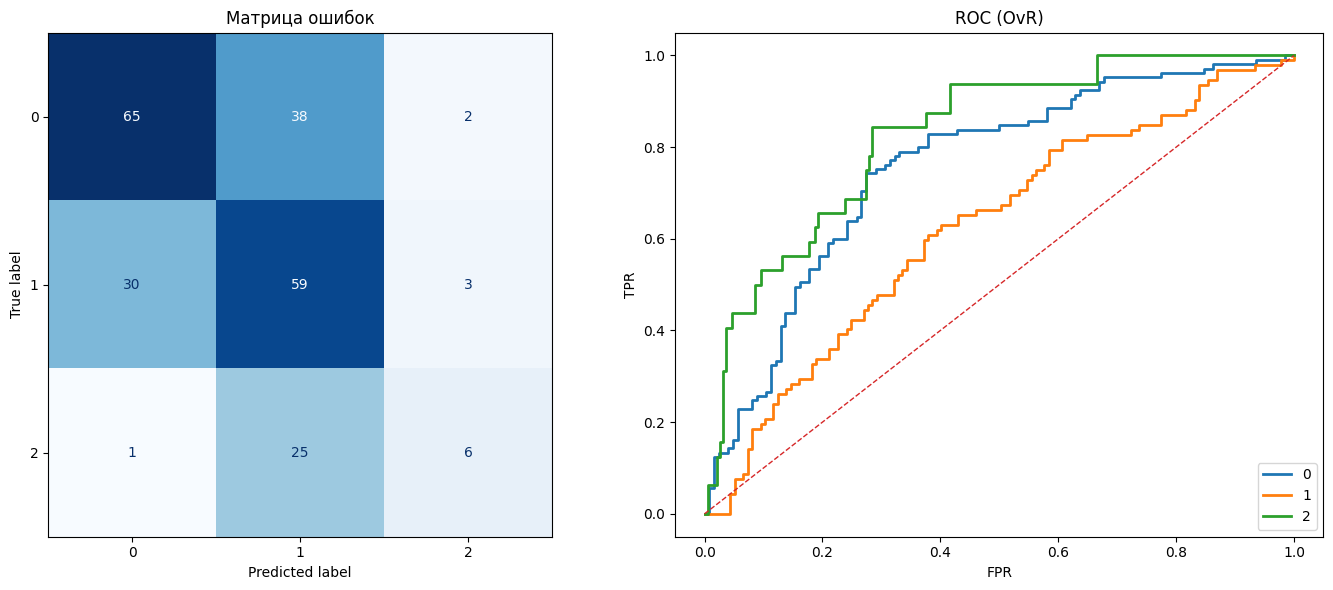

In [5]:
gnb = GaussianNB(var_smoothing=best_var)
gnb.fit(X_train_scaled, y_train)

y_pred = gnb.predict(X_test_scaled)
y_score = gnb.predict_proba(X_test_scaled)

bayes_metrics = get_metrics(y_test, y_pred, y_score)

Precision (точность) — доля правильно предсказанных объектов класса среди всех предсказанных этим классом.
Пример: для класса 0 → из всех объектов, которые модель предсказала как класс 0, 67.7% действительно оказались классом 0.

Recall (чувствительность) — доля объектов класса, которые модель правильно угадала.
Пример: для класса 2 → модель правильно предсказала только 18.7% всех «хороших» вин. Тут видно, что модель плохо распознаёт хорошие вина.

F1-score — гармоническое среднее precision и recall.
Чем ближе к 1 — тем лучше баланс между точностью и полнотой.
Для класса 2 F1 = 0.2791 → низкий показатель, что указывает на слабую способность модели обнаруживать хорошие вина.

ROC AUC — площадь под ROC-кривой для каждого класса (OvR).
Для класса 2 — 0.8277 → теоретически модель неплохо различает хорошие вина по вероятностям, хотя она мало их правильно классифицирует (низкий recall).
Это классическая ситуация для несбалансированных классов: модель «осторожничает» и редко выбирает редкий класс.

micro — метрика считается «по всем объектам», т.е. берутся все TP, FP, FN в сумме.

Accuracy = 0.5677 → 56.8% всех вин правильно классифицированы.

macro — метрика считается для каждого класса отдельно, потом усредняется.

Macro Recall = 0.4826 → среднее по классам чувствительность невысокая, т.к. класс 2 сильно занижает среднее.

weighted — среднее по классам, взвешенное по количеству объектов каждого класса.

Учитывает несбалансированность классов, поэтому чуть выше macro.

Выводы:

Модель хорошо распознаёт плохие вина (класс 0) — высокий precision и recall.

Средние вина (класс 1) — неплохо, но точность средняя.

Хорошие вина (класс 2) — проблема: low recall → модель редко выбирает этот класс.

Типичная ситуация для несбалансированных классов: большинство объектов в классе 0 и 1, класс 2 редкий.

ROC AUC показывает, что модель способна отличать классы по вероятностям, но порог предсказания стандартный (argmax) не оптимален для редкого класса.

Общая точность ≈ 56–57% — неплохо для простой GaussianNB на трёхклассовой задаче без подбора сложных гиперпараметров.

## Дерево решений
Дерево решений — это структура, в которой:
Внутренние узелы - решение по одному признаку (условие вида x ≤ 3.5);
Ветви - результат проверки условия;
Листы - итоговоые решения (класс).

Дерево строится сверху вниз жадным алгоритмом (перебором)
1. Выбираем лучший признак и порог, чтобы разделить данные на 2 подмножества
2.Разбиение выбирается по критерию качества: Gini, Entropy
3. Рекурсивно повторяем процесс для каждой ветки пока не остановимся если все объекты узла в одном классе

Критерии выбора разбиения:
Gini:  
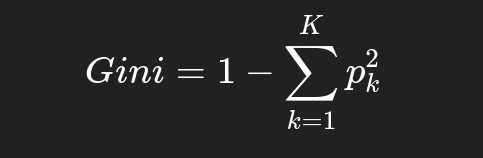  
где pk - доля объектов класса k в узле

Entropy:  
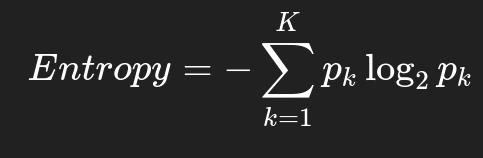  

### Подбор параметров

Будем перебирать следующие критерии:
- criterions — критерий качества разбиения (gini/entropy)
- max_depths — максимальная глубина дерева

In [6]:
from sklearn.tree import DecisionTreeClassifier
criterions = ['gini', 'entropy']
max_depths = list(range(1, 20)) 

best_score = 0
best_params = {}

print("Подбор параметров Decision Tree через кросс-валидацию...\n")

for crit in criterions:
    for depth in max_depths:
        dt = DecisionTreeClassifier(criterion=crit, max_depth=depth, random_state=56)
        scores = cross_val_score(dt, X_train_scaled, y_train, cv=5, scoring='accuracy')
        mean_score = scores.mean()
        print(f"criterion={crit}, max_depth={depth} -> Accuracy CV={mean_score:.4f}")
        
        if mean_score > best_score:
            best_score = mean_score
            best_params = {'criterion': crit, 'max_depth': depth}

print(f"\nЛучшие параметры: {best_params} с Accuracy CV={best_score:.4f}")

Подбор параметров Decision Tree через кросс-валидацию...

criterion=gini, max_depth=1 -> Accuracy CV=0.5733
criterion=gini, max_depth=2 -> Accuracy CV=0.5613
criterion=gini, max_depth=3 -> Accuracy CV=0.5580
criterion=gini, max_depth=4 -> Accuracy CV=0.5974
criterion=gini, max_depth=5 -> Accuracy CV=0.5973
criterion=gini, max_depth=6 -> Accuracy CV=0.5919
criterion=gini, max_depth=7 -> Accuracy CV=0.6105
criterion=gini, max_depth=8 -> Accuracy CV=0.6280
criterion=gini, max_depth=9 -> Accuracy CV=0.6203
criterion=gini, max_depth=10 -> Accuracy CV=0.6192
criterion=gini, max_depth=11 -> Accuracy CV=0.6214
criterion=gini, max_depth=12 -> Accuracy CV=0.6236
criterion=gini, max_depth=13 -> Accuracy CV=0.6214
criterion=gini, max_depth=14 -> Accuracy CV=0.6170
criterion=gini, max_depth=15 -> Accuracy CV=0.6203
criterion=gini, max_depth=16 -> Accuracy CV=0.6225
criterion=gini, max_depth=17 -> Accuracy CV=0.6214
criterion=gini, max_depth=18 -> Accuracy CV=0.6236
criterion=gini, max_depth=19 -> A

### Решение задачи классификации

Precision  Recall      F1 Accuracy  ROC AUC
Плохое       0.7419  0.6571  0.6970            0.7318
Среднее      0.5676  0.6848  0.6207            0.6672
Хорошее      0.6800  0.5312  0.5965            0.7453
micro        0.6507  0.6507  0.6507   0.6507   0.7380
macro        0.6632  0.6244  0.6381   0.6507   0.7148
weighted     0.6632  0.6507  0.6523   0.6507   0.7077

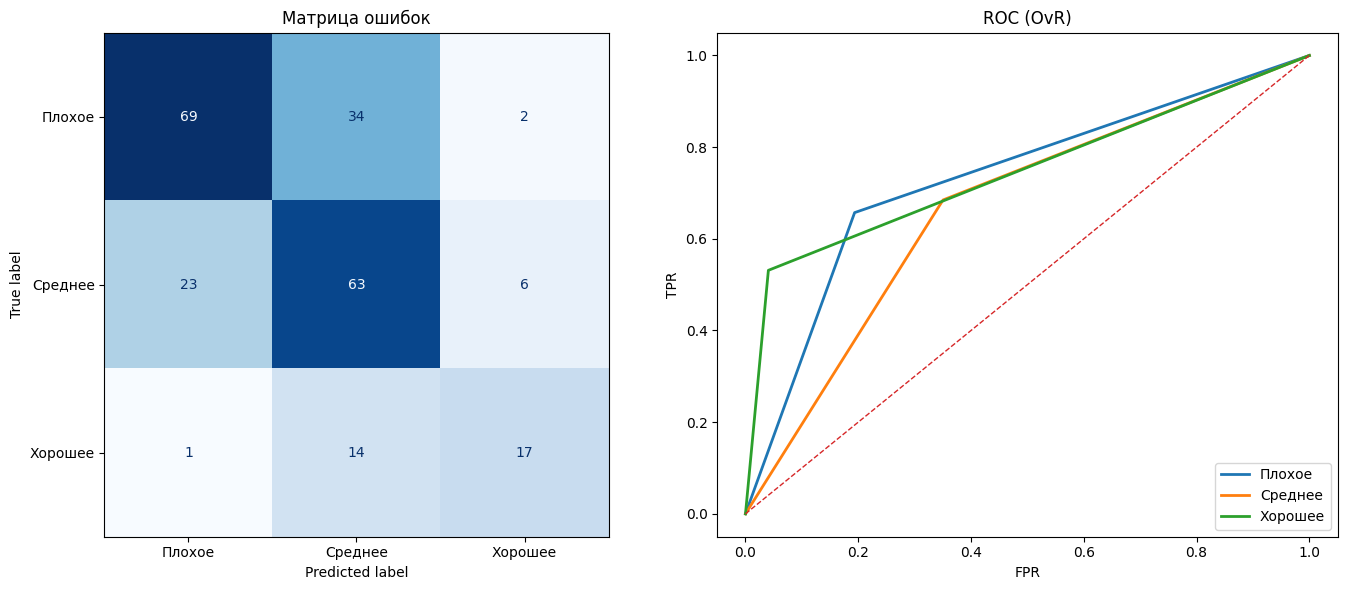

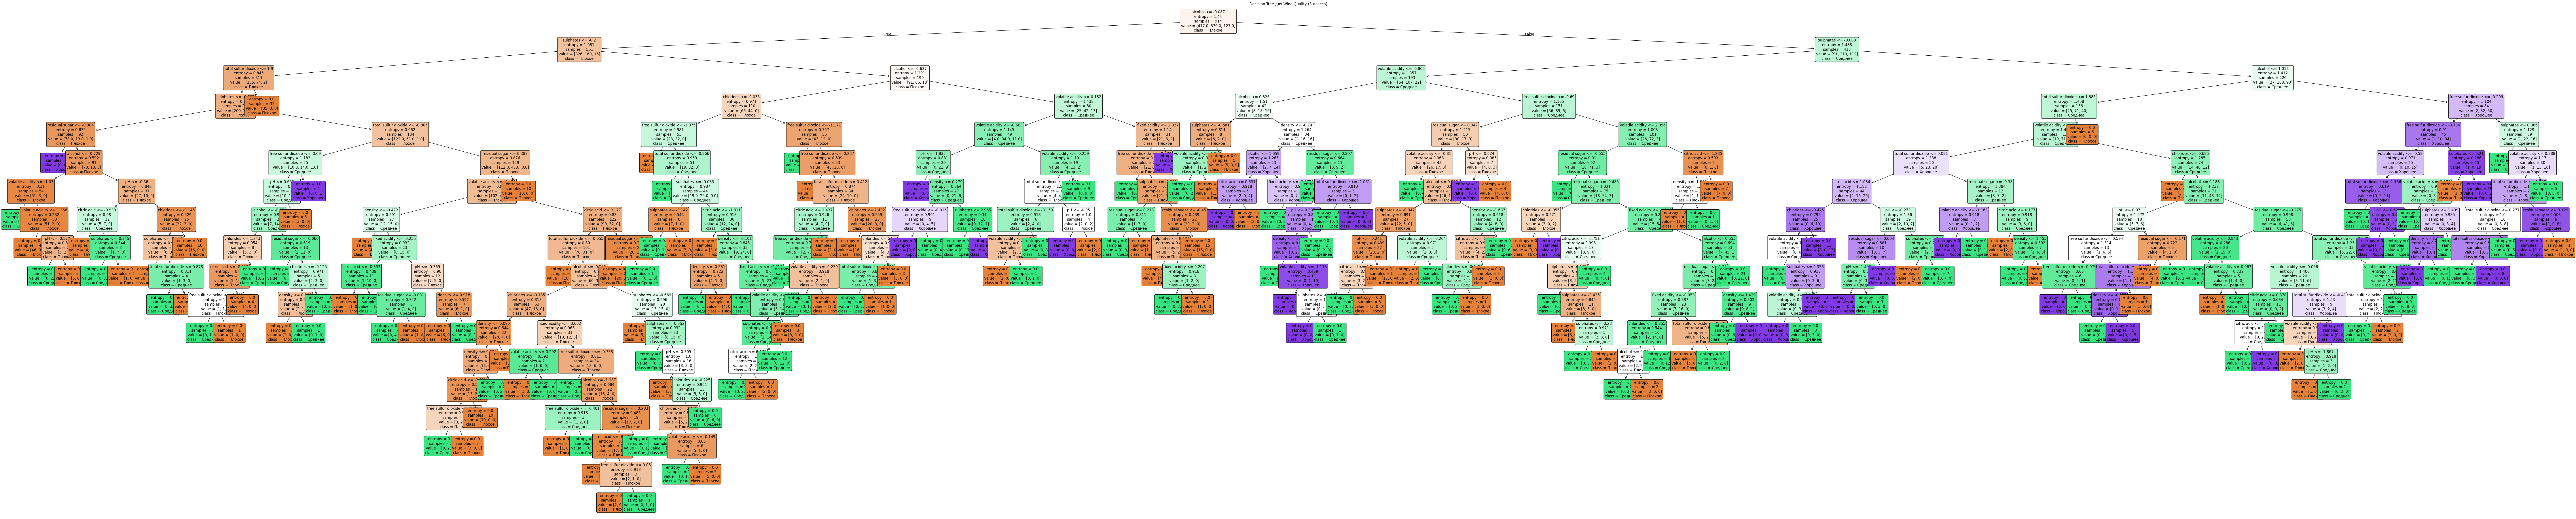

In [7]:
dt_best = DecisionTreeClassifier(
    criterion=best_params['criterion'],
    max_depth=best_params['max_depth'],
    random_state=56
)
dt_best.fit(X_train_scaled, y_train)

y_pred = dt_best.predict(X_test_scaled)

y_score = dt_best.predict_proba(X_test_scaled)

tree_metrics = get_metrics(y_test, y_pred, y_score, class_names=["Плохое","Среднее","Хорошее"])

from sklearn.tree import plot_tree

plt.figure(figsize=(150,30))
plot_tree(
    dt_best, 
    feature_names=X_train.columns, 
    class_names=["Плохое", "Среднее", "Хорошее"], 
    filled=True,
    rounded=True,
    fontsize=12
)
plt.title("Decision Tree для Wine Quality (3 класса)")
plt.show()

### Линейный дискриминантный анализ анализ
Строит линейные комбинации признаков, которые максимально разделяют классы.

Основная идея: проецировать данные на пространство меньшей размерности (до n_classes - 1) так, чтобы межклассовая дисперсия была максимальной, а внутриклассовая — минимальной.
После этого для новых объектов вычисляется вероятность принадлежности к каждому классу.
То есть он находит направление (вектор), вдоль которого центры классов находятся как можно дальше друг от друга.

### Подбор параметров

Какие параметры можно подбирать.
1. solver - метод решения
    - svd - по умолчанию
    - lsqr - метод наименьших квадратов
    - eigen - собственные значения/векторы
3. shrinkage - регуляризация ковариационной матрицы
    - None - без регуляризации, чистая оценка ковариации.
    - auto - автоматический подбор
    - от 0 до 1

Подбор параметров LDA...

solver=svd -> Accuracy CV=0.6598
solver=lsqr, shrinkage=None -> Accuracy CV=0.6608
solver=lsqr, shrinkage=0.01 -> Accuracy CV=0.6587
solver=lsqr, shrinkage=0.1 -> Accuracy CV=0.6466
solver=lsqr, shrinkage=0.3 -> Accuracy CV=0.6466
solver=lsqr, shrinkage=0.5 -> Accuracy CV=0.6433
solver=lsqr, shrinkage=0.7 -> Accuracy CV=0.6422
solver=lsqr, shrinkage=1.0 -> Accuracy CV=0.6182
solver=eigen, shrinkage=None -> Accuracy CV=0.6608
solver=eigen, shrinkage=0.01 -> Accuracy CV=0.6587
solver=eigen, shrinkage=0.1 -> Accuracy CV=0.6466
solver=eigen, shrinkage=0.3 -> Accuracy CV=0.6466
solver=eigen, shrinkage=0.5 -> Accuracy CV=0.6433
solver=eigen, shrinkage=0.7 -> Accuracy CV=0.6422
solver=eigen, shrinkage=1.0 -> Accuracy CV=0.6182

Лучшие параметры: solver=lsqr, shrinkage=None -> Accuracy CV=0.6608


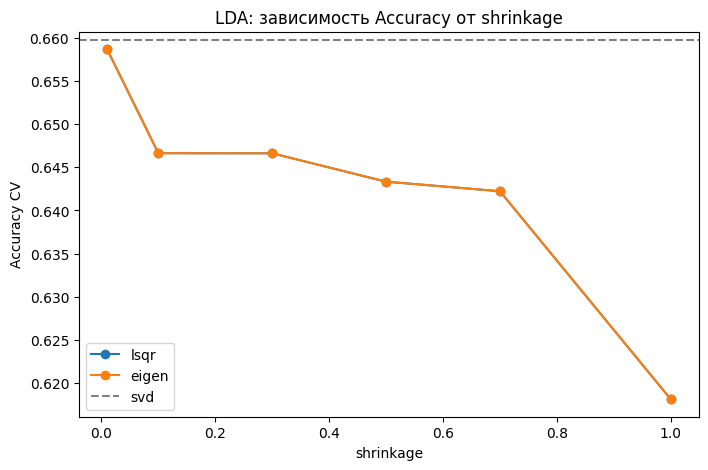

In [8]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import numpy as np

solvers = ['svd', 'lsqr', 'eigen']
shrinkages = [None, 0.01, 0.1, 0.3, 0.5, 0.7, 1.0]

results = []

print("Подбор параметров LDA...\n")
for solver in solvers:
    if solver == 'svd':
        lda = LinearDiscriminantAnalysis(solver=solver)
        scores = cross_val_score(lda, X_train_scaled, y_train, cv=5, scoring='accuracy')
        mean_score = scores.mean()
        results.append((solver, None, mean_score))
        print(f"solver={solver} -> Accuracy CV={mean_score:.4f}")
    else:
        for shrink in shrinkages:
            lda = LinearDiscriminantAnalysis(solver=solver, shrinkage=shrink)
            scores = cross_val_score(lda, X_train_scaled, y_train, cv=5, scoring='accuracy')
            mean_score = scores.mean()
            results.append((solver, shrink, mean_score))
            print(f"solver={solver}, shrinkage={shrink} -> Accuracy CV={mean_score:.4f}")

best_result = max(results, key=lambda x: x[2])
best_solver, best_shrink, best_score = best_result
print(f"\nЛучшие параметры: solver={best_solver}, shrinkage={best_shrink} -> Accuracy CV={best_score:.4f}")

plt.figure(figsize=(8,5))
for solver in ['lsqr','eigen']:
    accs = [r[2] for r in results if r[0]==solver]
    shr = [r[1] for r in results if r[0]==solver]
    plt.plot(shr, accs, marker='o', label=solver)
plt.axhline(y=[r[2] for r in results if r[0]=='svd'][0], color='gray', linestyle='--', label='svd')
plt.xlabel("shrinkage")
plt.ylabel("Accuracy CV")
plt.title("LDA: зависимость Accuracy от shrinkage")
plt.legend()
plt.show()

### Задача классификации

Precision  Recall      F1 Accuracy  ROC AUC
Плохое       0.6916  0.7048  0.6981            0.7781
Среднее      0.5393  0.5217  0.5304            0.6361
Хорошее      0.4848  0.5000  0.4923            0.8602
micro        0.6026  0.6026  0.6026   0.6026   0.7894
macro        0.5719  0.5755  0.5736   0.6026   0.7581
weighted     0.6015  0.6026  0.6020   0.6026   0.7325

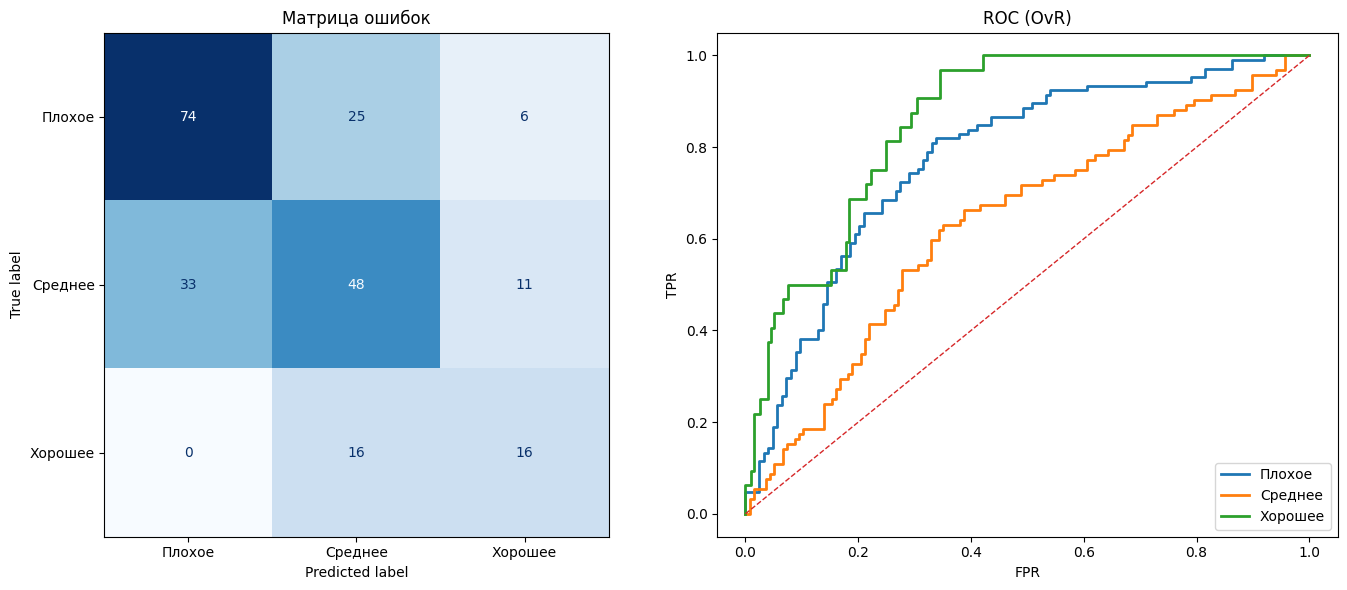

In [9]:
lda_best = LinearDiscriminantAnalysis(solver=best_solver, shrinkage=best_shrink)
lda_best.fit(X_train_scaled, y_train)

y_pred = lda_best.predict(X_test_scaled)
y_score = lda_best.predict_proba(X_test_scaled)
lda_metrics = get_metrics(y_test, y_pred, y_score, class_names=["Плохое","Среднее","Хорошее"])

## Метод опорных векторов

Метод опорных векторов — это алгоритм классификации, который строит гиперплоскость (или множество гиперплоскостей) в многомерном пространстве, которая максимально разделяет классы.

Основная идея: максимизировать отступ между классами. Для нелинейно разделимых данных используется ядровая функция для проекции в более высокое пространство.

### Побор параметров метода
Основные параметры, которые можно подбирать:

C — коэффициент регуляризации.

kernel - тип ядра:
linear - линейное разделение.  
poly - полиномиальное ядро.  
rbf - радиальное базисное (Gaussian) ядро, чаще всего используется.  
sigmoid - сигмоидальное ядро.  
gamma - для rbf, poly, sigmoid. Определяет ширину ядра:  
Малое - гладкая граница.  
Большое - сложная граница, возможен перезаполнение.  

In [10]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
import numpy as np

C_values = [0.1, 1, 10, 50]
gamma_values = [0.01, 0.1, 0.5, 1]

best_score = 0
best_params = {}

print("Подбор параметров SVM (RBF kernel)...\n")
for C in C_values:
    for gamma in gamma_values:
        svm = SVC(C=C, kernel='rbf', gamma=gamma, probability=True, random_state=56)
        scores = cross_val_score(svm, X_train_scaled, y_train, cv=5, scoring='accuracy')
        mean_score = scores.mean()
        print(f"C={C}, gamma={gamma} -> Accuracy CV={mean_score:.4f}")
        
        if mean_score > best_score:
            best_score = mean_score
            best_params = {'C': C, 'gamma': gamma}

print(f"\nЛучшие параметры: C={best_params['C']}, gamma={best_params['gamma']} -> Accuracy CV={best_score:.4f}")

Подбор параметров SVM (RBF kernel)...

C=0.1, gamma=0.01 -> Accuracy CV=0.5799
C=0.1, gamma=0.1 -> Accuracy CV=0.6193
C=0.1, gamma=0.5 -> Accuracy CV=0.4836
C=0.1, gamma=1 -> Accuracy CV=0.4562
C=1, gamma=0.01 -> Accuracy CV=0.6215
C=1, gamma=0.1 -> Accuracy CV=0.6520
C=1, gamma=0.5 -> Accuracy CV=0.6575
C=1, gamma=1 -> Accuracy CV=0.6302
C=10, gamma=0.01 -> Accuracy CV=0.6433
C=10, gamma=0.1 -> Accuracy CV=0.6794
C=10, gamma=0.5 -> Accuracy CV=0.6379
C=10, gamma=1 -> Accuracy CV=0.6324
C=50, gamma=0.01 -> Accuracy CV=0.6433
C=50, gamma=0.1 -> Accuracy CV=0.6302
C=50, gamma=0.5 -> Accuracy CV=0.6379
C=50, gamma=1 -> Accuracy CV=0.6302

Лучшие параметры: C=10, gamma=0.1 -> Accuracy CV=0.6794


### Решение задачи классификации

Precision  Recall      F1 Accuracy  ROC AUC
Плохое       0.7315  0.7524  0.7418            0.8290
Среднее      0.6154  0.6087  0.6120            0.7308
Хорошее      0.5667  0.5312  0.5484            0.8309
micro        0.6638  0.6638  0.6638   0.6638   0.8309
macro        0.6378  0.6308  0.6341   0.6638   0.7969
weighted     0.6618  0.6638  0.6626   0.6638   0.7898

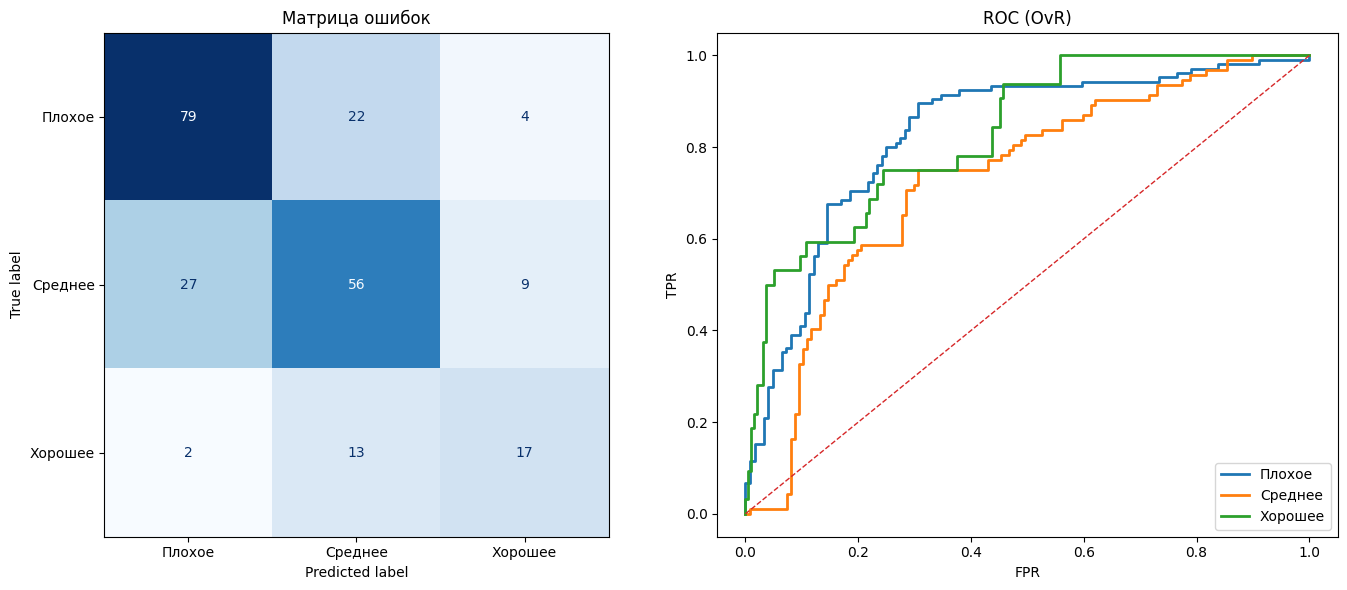

In [11]:
svm_best = SVC(
    C=best_params['C'], 
    kernel='rbf', 
    gamma=best_params['gamma'], 
    probability=True,
    random_state=56
)

svm_best.fit(X_train_scaled, y_train)

y_pred = svm_best.predict(X_test_scaled)
y_score = svm_best.predict_proba(X_test_scaled)

svm_metrics = get_metrics(y_test, y_pred, y_score, class_names=["Плохое","Среднее","Хорошее"])

## Метод k ближайших соседей
KNN (k-ближайших соседей):
1. Задаём число соседей: k.
2. Для нового объекта считаем расстояния до всех объектов в обучении.
3. Сортируем по расстоянию, выбираем k маленьких.
4. Голосуем / усредняем.

Для вычисления расстояния можно использовать разные метрики.  
Евклидово расстояние:  
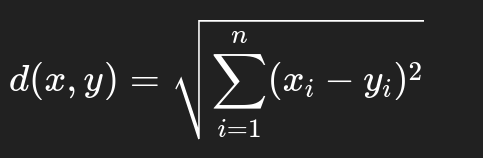  
Манхэттенское расстояние:   
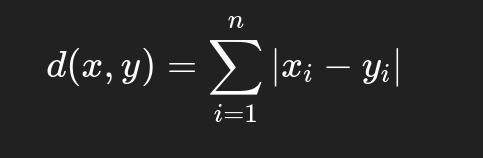   
Расстояние Минковского:   
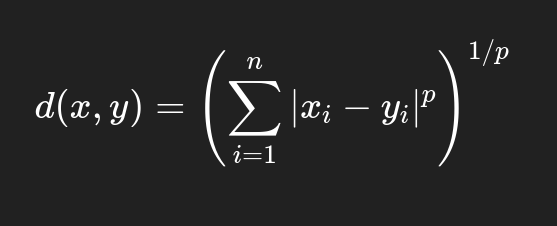    
Расстояние Чебышева:   
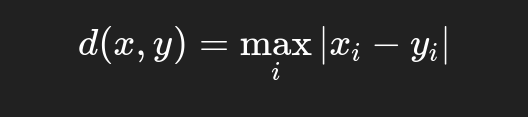    

### Подбор параметров метода
Основные параметры:

n_neighbors - количество соседей k.
weights - способ голосования:  
uniform - каждый сосед голосует одинаково.  
distance - вес пропорционален обратной дистанции.  
metric - метрика расстояния (minkowski с p=2 = Евклидово расстояние).

Будем подбирать n_neighbors и weights. Метрика - minkowski

Подбор параметров kNN...

k=1, weights=uniform -> Accuracy CV=0.6302
k=2, weights=uniform -> Accuracy CV=0.5919
k=3, weights=uniform -> Accuracy CV=0.5678
k=4, weights=uniform -> Accuracy CV=0.6006
k=5, weights=uniform -> Accuracy CV=0.5820
k=6, weights=uniform -> Accuracy CV=0.6061
k=7, weights=uniform -> Accuracy CV=0.6039
k=8, weights=uniform -> Accuracy CV=0.6028
k=9, weights=uniform -> Accuracy CV=0.6192
k=10, weights=uniform -> Accuracy CV=0.6050
k=11, weights=uniform -> Accuracy CV=0.6050
k=12, weights=uniform -> Accuracy CV=0.6018
k=13, weights=uniform -> Accuracy CV=0.5886
k=14, weights=uniform -> Accuracy CV=0.6061
k=15, weights=uniform -> Accuracy CV=0.6007
k=16, weights=uniform -> Accuracy CV=0.6018
k=17, weights=uniform -> Accuracy CV=0.6029
k=18, weights=uniform -> Accuracy CV=0.5952
k=19, weights=uniform -> Accuracy CV=0.6029
k=20, weights=uniform -> Accuracy CV=0.5974
k=1, weights=distance -> Accuracy CV=0.6302
k=2, weights=distance -> Accuracy CV=0.6302
k=3, weights=di

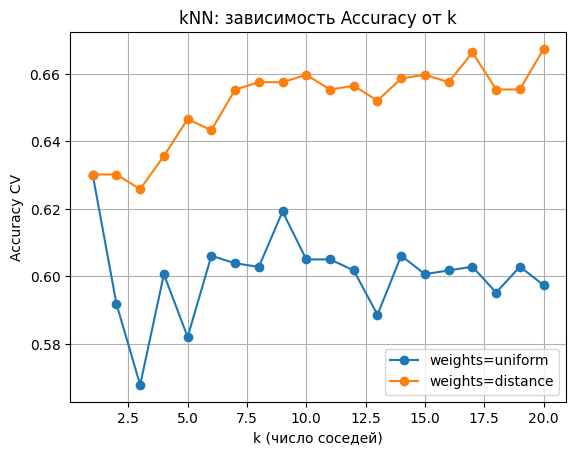


Лучшие параметры: k=20, weights=distance -> Accuracy CV=0.6674


In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import numpy as np

k_values = range(1, 21)
weights_options = ['uniform', 'distance']

results = []

print("Подбор параметров kNN...\n")
for weights in weights_options:
    acc_list = []
    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k, weights=weights)
        scores = cross_val_score(knn, X_train_scaled, y_train, cv=5, scoring='accuracy')
        mean_score = scores.mean()
        acc_list.append(mean_score)
        results.append((k, weights, mean_score))
        print(f"k={k}, weights={weights} -> Accuracy CV={mean_score:.4f}")
    
    plt.plot(k_values, acc_list, marker='o', label=f"weights={weights}")

plt.xlabel("k (число соседей)")
plt.ylabel("Accuracy CV")
plt.title("kNN: зависимость Accuracy от k")
plt.legend()
plt.grid(True)
plt.show()

best_result = max(results, key=lambda x: x[2])
best_k, best_weights, best_score = best_result
print(f"\nЛучшие параметры: k={best_k}, weights={best_weights} -> Accuracy CV={best_score:.4f}")

### Решение задачи классификации


Precision  Recall      F1 Accuracy  ROC AUC
Плохое       0.7570  0.7714  0.7642            0.8577
Среднее      0.6277  0.6413  0.6344            0.7790
Хорошее      0.5714  0.5000  0.5333            0.8426
micro        0.6812  0.6812  0.6812   0.6812   0.8596
macro        0.6520  0.6376  0.6440   0.6812   0.8264
weighted     0.6791  0.6812  0.6798   0.6812   0.8240

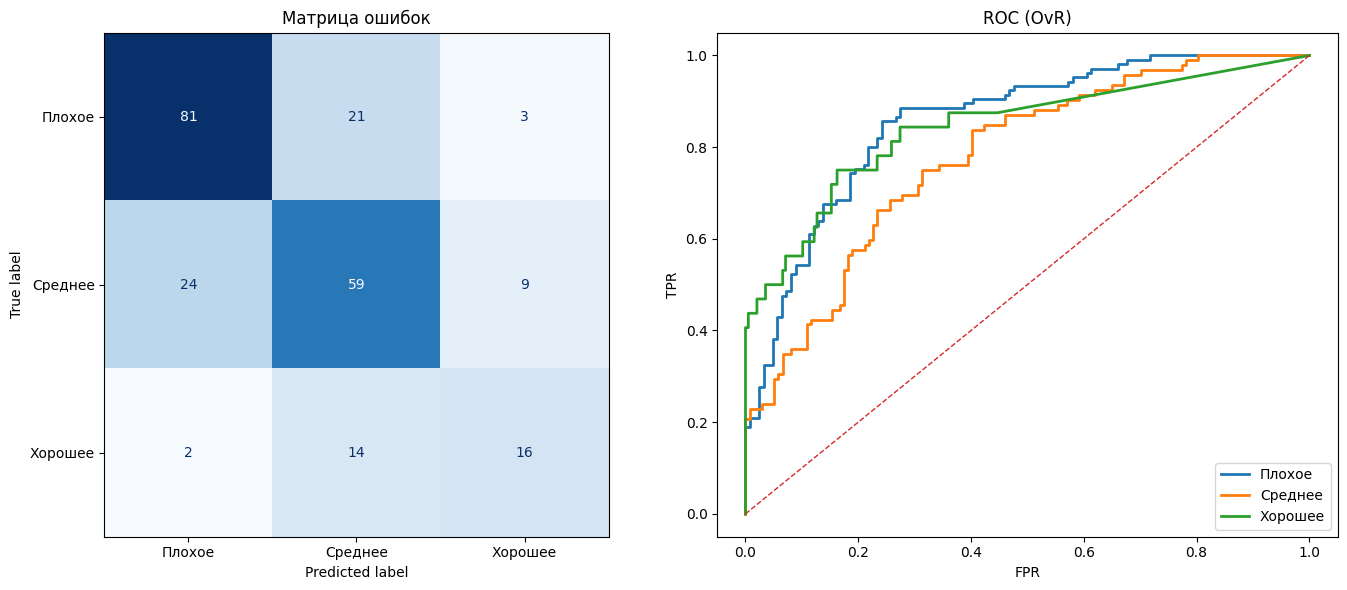

In [13]:
knn_best = KNeighborsClassifier(n_neighbors=best_k, weights=best_weights)
knn_best.fit(X_train_scaled, y_train)

y_pred = knn_best.predict(X_test_scaled)
y_score = knn_best.predict_proba(X_test_scaled)
knn_metrics = get_metrics(y_test, y_pred, y_score, class_names=["Плохое","Среднее","Хорошее"])

## Сравнение алгоритмов

Precision  Recall      F1 Accuracy ROC AUC
K-Neighbors      0.6791  0.6812  0.6798   0.6812   0.824
SVM              0.6618  0.6638  0.6626   0.6638  0.7898
Decision Tree    0.6632  0.6507  0.6523   0.6507  0.7077
LDA              0.6015  0.6026   0.602   0.6026  0.7325
Naive Bayes       0.581  0.5677  0.5571   0.5677  0.7137

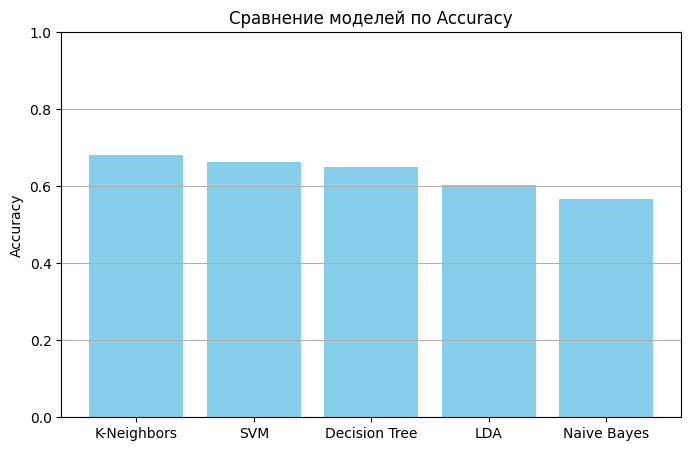

In [14]:
import pandas as pd

summary_compact = pd.DataFrame({
    'Naive Bayes': bayes_metrics.loc['weighted'],
    'Decision Tree': tree_metrics.loc['weighted'], 
    'LDA': lda_metrics.loc['weighted'],
    'SVM': svm_metrics.loc['weighted'],
    'K-Neighbors': knn_metrics.loc['weighted']
}).T

summary_compact = summary_compact[['Precision', 'Recall', 'F1', 'Accuracy', 'ROC AUC']]

summary_compact = summary_compact.sort_values('Accuracy', ascending=False)

display(summary_compact)

import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.bar(summary_compact.index, summary_compact['Accuracy'], color='skyblue')
plt.ylabel("Accuracy")
plt.title("Сравнение моделей по Accuracy")
plt.ylim(0,1)
plt.grid(axis='y')
plt.show()

### Выводы
KNN - лучшая модель.  
Accuracy: 0.6791  
F1: 0.6798  
ROC-AUC: 0.824  
KNN обеспечивает лучшую общую производительность, особенно по ROC-AUC, что говорит о хорошей способности отделять классы. Все метрики сбалансированы. Видимо окальная структура данных хорошо подходит для ближайших соседей, вероятно, классы неплохо разделены в пространстве признаков.

SVM показывает стабильные результаты чуть хуже KNN.

Дерево решений работает средне: метрики хуже алгоритмов выше, но ROC-AUC всё ещё приемлемый.

LDA показывает средние результаты, примерно на уровне дерева решений.

Байесовский алгоритм показывает наименьшие значения всех ключевых метрик.
Причина: модель предполагает независимость признаков, что редко выполняется в реальных данных. Из-за этого теряется информация и падает точность.

# Нейронная сеть
Входной слой: 1 слой - на вход приходят данные датасета  
Скрытые слои: 2 слоя (128 и 64 нейрона), ReLU, BatchNorm + Dropout  
Выходной слой: 1 слой, 3 нейрона, Softmax  
Функция активации: ReLU (скрытые), Softmax (выход)  
Функция потерь: sparse_categorical_crossentropy  
Оптимизатор: Adam (learning_rate=0.001)  

2025-12-19 15:46:41.996731: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-19 15:46:42.034714: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-19 15:46:43.173002: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


Epoch 1/100


/home/nikita/Machine-Learning/Lab-3/venv/lib64/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-12-19 15:46:43.579588: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4630 - loss: 1.3533 - val_accuracy: 0.8207 - val_loss: 0.8057
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5640 - loss: 1.0564 - val_accuracy: 0.8167 - val_loss: 0.7507
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5840 - loss: 0.9835 - val_accuracy: 0.8088 - val_loss: 0.7224
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6040 - loss: 0.9151 - val_accuracy: 0.7888 - val_loss: 0.7113
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5840 - loss: 0.9083 - val_accuracy: 0.7729 - val_loss: 0.6766
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6060 - loss: 0.8809 - val_accuracy: 0.7928 - val_loss: 0.6756
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6310 - loss: 0.8470 - val_accuracy: 0.8048 - val_loss: 0.6289
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6570 - loss: 0.7832 - val_accuracy: 0.7928 - val_loss: 0.

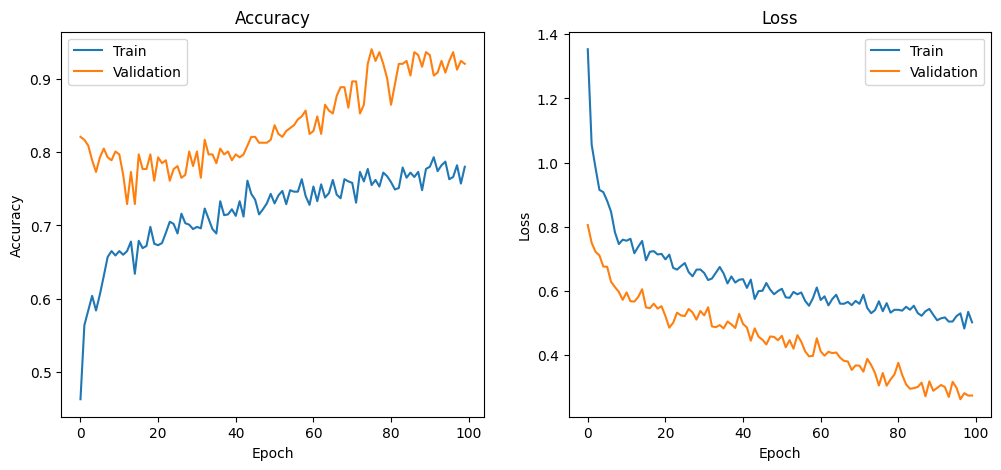

Test Accuracy: 0.6769, Test Loss: 0.9142
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


Precision  Recall      F1 Accuracy  ROC AUC
Плохое       0.7593  0.7810  0.7700            0.8399
Среднее      0.6333  0.6196  0.6264            0.7344
Хорошее      0.5161  0.5000  0.5079            0.7719
micro        0.6769  0.6769  0.6769   0.6769   0.8234
macro        0.6362  0.6335  0.6348   0.6769   0.7820
weighted     0.6747  0.6769  0.6757   0.6769   0.7880

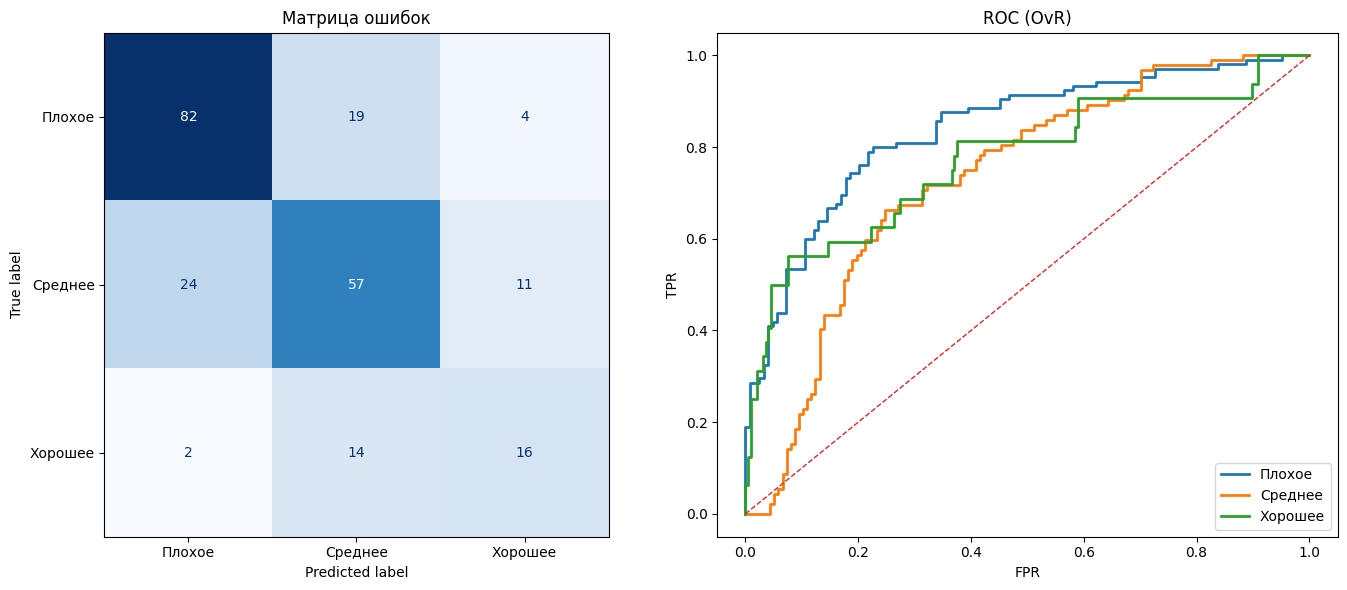

Precision  Recall      F1 Accuracy  ROC AUC
Плохое       0.7593  0.7810  0.7700            0.8399
Среднее      0.6333  0.6196  0.6264            0.7344
Хорошее      0.5161  0.5000  0.5079            0.7719
micro        0.6769  0.6769  0.6769   0.6769   0.8234
macro        0.6362  0.6335  0.6348   0.6769   0.7820
weighted     0.6747  0.6769  0.6757   0.6769   0.7880

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
import datetime
import matplotlib.pyplot as plt
import numpy as np


smote = SMOTE(random_state=56)
X_res, y_res = smote.fit_resample(X_train_scaled, y_train)

class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_res),
    y=y_res
)
class_weights = dict(enumerate(class_weights_array))

input_dim = X_res.shape[1]
num_classes = 3

def create_model(hidden_layers=[128,64], dropout_rate=0.3, learning_rate=0.001):
    model = Sequential()
    
    model.add(Dense(hidden_layers[0], input_dim=input_dim, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    for units in hidden_layers[1:]:
        model.add(Dense(units, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))
    
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

model = create_model(hidden_layers=[128,64], dropout_rate=0.3, learning_rate=0.001)

history = model.fit(
    X_res, y_res,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[tensorboard_callback, early_stop],
    verbose=1
)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

test_loss, test_acc = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

y_score_nn = model.predict(X_test_scaled)
y_pred_nn = y_score_nn.argmax(axis=1)

get_metrics(y_test, y_pred_nn, y_score_nn, class_names=["Плохое","Среднее","Хорошее"])

Видно, что при классификации с помощью нейросети метрика weighted получилась ~0,65, что не сильно лучше чем в предидущих метода. Значит нейросеть кардинально не смогла улучшить классификацию.